# Notebook setup


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)


Mounted at /content/drive


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import pandas as pd
from shutil import copyfile

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau, CSVLogger
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import load_model


from time import time

models_path = '/content/drive/MyDrive/deep_learning_models_11_classes'

os.makedirs(models_path, exist_ok = True)


In [3]:
CAMVID_CLASSES = {
    'Animal': (64, 128, 64),
    'Archway': (192, 0, 128),
    'Bicyclist': (0, 128, 192),
    'Bridge': (0, 128, 64),
    'Building': (128, 0, 0),
    'Car': (64, 0, 128),
    'CartLuggagePram': (64, 0, 192),
    'Child': (192, 128, 64),
    'Column_Pole': (192, 192, 128),
    'Fence': (64, 64, 128),
    'LaneMkgsDriv': (128, 0, 192),
    'LaneMkgsNonDriv': (192, 0, 64),
    'Misc_Text': (128, 128, 64),
    'MotorcycleScooter': (192, 0, 192),
    'OtherMoving': (128, 64, 64),
    'ParkingBlock': (64, 192, 128),
    'Pedestrian': (64, 64, 0),
    'Road': (128, 64, 128),
    'RoadShoulder': (128, 128, 192),
    'Sidewalk': (0, 0, 192),
    'SignSymbol': (192, 128, 128),
    'Sky': (128, 128, 128),
    'SUVPickupTruck': (64, 128, 192),
    'TrafficCone': (0, 0, 64),
    'TrafficLight': (0, 64, 64),
    'Train': (192, 64, 128),
    'Tree': (128, 128, 0),
    'Truck_Bus': (192, 128, 192),
    'Tunnel': (64, 0, 64),
    'VegetationMisc': (192, 192, 0),
    'Void': (0, 0, 0),
    'Wall': (64, 192, 0)
}

CAMVID_CLASSES_GROUPED = {
    'Sky': ['Sky'],
    'Building': ['Archway', 'Bridge', 'Building', 'Tunnel', 'Wall'],
    'Pole': ['Column_Pole', 'TrafficCone'],  # Usando 'Pole' invece di 'Column_Pole'
    'Road': ['Road', 'LaneMkgsDriv', 'LaneMkgsNonDriv'],
    'Sidewalk': ['Sidewalk', 'ParkingBlock', 'RoadShoulder'],
    'Tree': ['Tree', 'VegetationMisc'],
    'Sign': ['TrafficLight', 'Misc_Text', 'SignSymbol'],  # Usando 'Sign' invece di 'TrafficLight'
    'Fence': ['Fence'],
    'Car': ['Car', 'OtherMoving', 'SUVPickupTruck', 'Train', 'Truck_Bus'],
    'Pedestrian': ['Animal', 'CartLuggagePram', 'Child', 'Pedestrian'],
    'Bicyclist': ['Bicyclist', 'MotorcycleScooter'],
    'Void': ['Void']  # Aggiungi la classe Void

}

GROUPED_CLASS_COLORS = {
    'Sky': (128, 128, 128),
    'Building': (128, 0, 0),
    'Pole': (192, 192, 128),
    'Road': (128, 64, 128),
    'Sidewalk': (0, 0, 192),
    'Tree': (128, 128, 0),
    'Sign': (192, 128, 128),
    'Fence': (64, 64, 128),
    'Car': (64, 0, 128),
    'Pedestrian': (64, 64, 0),
    'Bicyclist': (0, 128, 192),
    'Void': (0,0,0)
}
num_classes = len(CAMVID_CLASSES_GROUPED)


In [4]:
t0 = time()
# Transfer zip dataset to the current virtual machine
copyfile('/content/drive/MyDrive/semantic-segmentation-camvid/Data/raw.zip', 'raw.zip')
# Extract files
zipp = zipfile.ZipFile('raw.zip')

data_raw_path = '/content/data/'

zipp.extractall(data_raw_path)
zipp.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 45.511 seconds


# Data Loading and Preprocessing

In [5]:
#train test split
base_dir = "/content/data/raw"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

train_dir = "/content/data/processed/train"
test_dir = "/content/data/processed/test"

train_images_dir = os.path.join(train_dir, "images")
train_labels_dir = os.path.join(train_dir, "labels")
test_images_dir = os.path.join(test_dir, "images")
test_labels_dir = os.path.join(test_dir, "labels")

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)


In [6]:
all_images = os.listdir(images_dir)
all_images.sort()

seed_value = 42
np.random.seed(seed_value)
np.random.shuffle(all_images)

train_size = int(0.8 * len(all_images))
train_images = all_images[:train_size]
test_images = all_images[train_size:]

# Copia le immagini e le maschere nel set di addestramento
for image_file in train_images:
    shutil.copy(os.path.join(images_dir, image_file), os.path.join(train_images_dir, image_file))
    # Aggiungi "_L" al nome file per la maschera
    label_file = image_file[:-4] + '_L.png'  # Rimuove '.png' e aggiunge '_L.png'
    shutil.copy(os.path.join(labels_dir, label_file), os.path.join(train_labels_dir, label_file))

# Copia le immagini e le maschere nel set di test
for image_file in test_images:
    shutil.copy(os.path.join(images_dir, image_file), os.path.join(test_images_dir, image_file))
    label_file = image_file[:-4] + '_L.png'
    shutil.copy(os.path.join(labels_dir, label_file), os.path.join(test_labels_dir, label_file))



In [7]:
CAMVID_CLASSES_TO_GROUP = {}
for key, values in CAMVID_CLASSES_GROUPED.items():
    for value in values:
        CAMVID_CLASSES_TO_GROUP[value] = key

# Function to convert original class labels to grouped labels
def convert_labels_to_grouped(labels, class_to_group_map):
    grouped_labels = np.copy(labels)
    for original_class, grouped_class in class_to_group_map.items():
        original_class_index = list(CAMVID_CLASSES.keys()).index(original_class)
        grouped_class_index = list(CAMVID_CLASSES_GROUPED.keys()).index(grouped_class)
        grouped_labels[labels == original_class_index] = grouped_class_index
    return grouped_labels

class CamVidDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, class_colors, batch_size=16, target_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.class_colors = class_colors
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i: i + self.batch_size]
        batch_mask_paths = self.mask_paths[i: i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.target_size + (3,), dtype='float32')
        y = np.zeros((self.batch_size,) + self.target_size, dtype='int32')  # 2D labels

        for j, (image_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            img = load_img(image_path, target_size=self.target_size)
            mask = load_img(mask_path, target_size=self.target_size, color_mode='rgb')

            img = img_to_array(img)
            mask = img_to_array(mask)

            mask = self.form_2D_label(mask)

            x[j] = img / 255.0
            y[j] = mask  # assign 2D labels

        return x, y

    def form_2D_label(self, mask):
        label = np.zeros(mask.shape[:2], dtype=np.uint8)
        for i, rgb in enumerate(self.class_colors):
            label[(mask == rgb).all(axis=-1)] = i

        # Convert labels to grouped labels
        label = convert_labels_to_grouped(label, CAMVID_CLASSES_TO_GROUP)

        return label

# Uso del generatore:
from sklearn.model_selection import train_test_split

# Percorsi immagini e maschere
image_paths = [os.path.join('data/processed/train/images', fname) for fname in os.listdir('data/processed/train/images')]
mask_paths = [os.path.join('data/processed/train/labels', fname) for fname in os.listdir('data/processed/train/labels')]

# Assicurati che i percorsi siano ordinati e corrispondenti
image_paths.sort()
mask_paths.sort()

# Split in train e validation
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Creazione del generatore
train_gen = CamVidDataGenerator(train_images, train_masks, list(CAMVID_CLASSES.values()))
val_gen = CamVidDataGenerator(val_images, val_masks, list(CAMVID_CLASSES.values()))



In [ ]:
CAMVID_CLASSES_TO_GROUP

{'Sky': 'Sky',
 'Archway': 'Building',
 'Bridge': 'Building',
 'Building': 'Building',
 'Tunnel': 'Building',
 'Wall': 'Building',
 'Column_Pole': 'Pole',
 'TrafficCone': 'Pole',
 'Road': 'Road',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Sidewalk': 'Sidewalk',
 'ParkingBlock': 'Sidewalk',
 'RoadShoulder': 'Sidewalk',
 'Tree': 'Tree',
 'VegetationMisc': 'Tree',
 'TrafficLight': 'Sign',
 'Misc_Text': 'Sign',
 'SignSymbol': 'Sign',
 'Fence': 'Fence',
 'Car': 'Car',
 'OtherMoving': 'Car',
 'SUVPickupTruck': 'Car',
 'Train': 'Car',
 'Truck_Bus': 'Car',
 'Animal': 'Pedestrian',
 'CartLuggagePram': 'Pedestrian',
 'Child': 'Pedestrian',
 'Pedestrian': 'Pedestrian',
 'Bicyclist': 'Bicyclist',
 'MotorcycleScooter': 'Bicyclist',
 'Void': 'Void'}

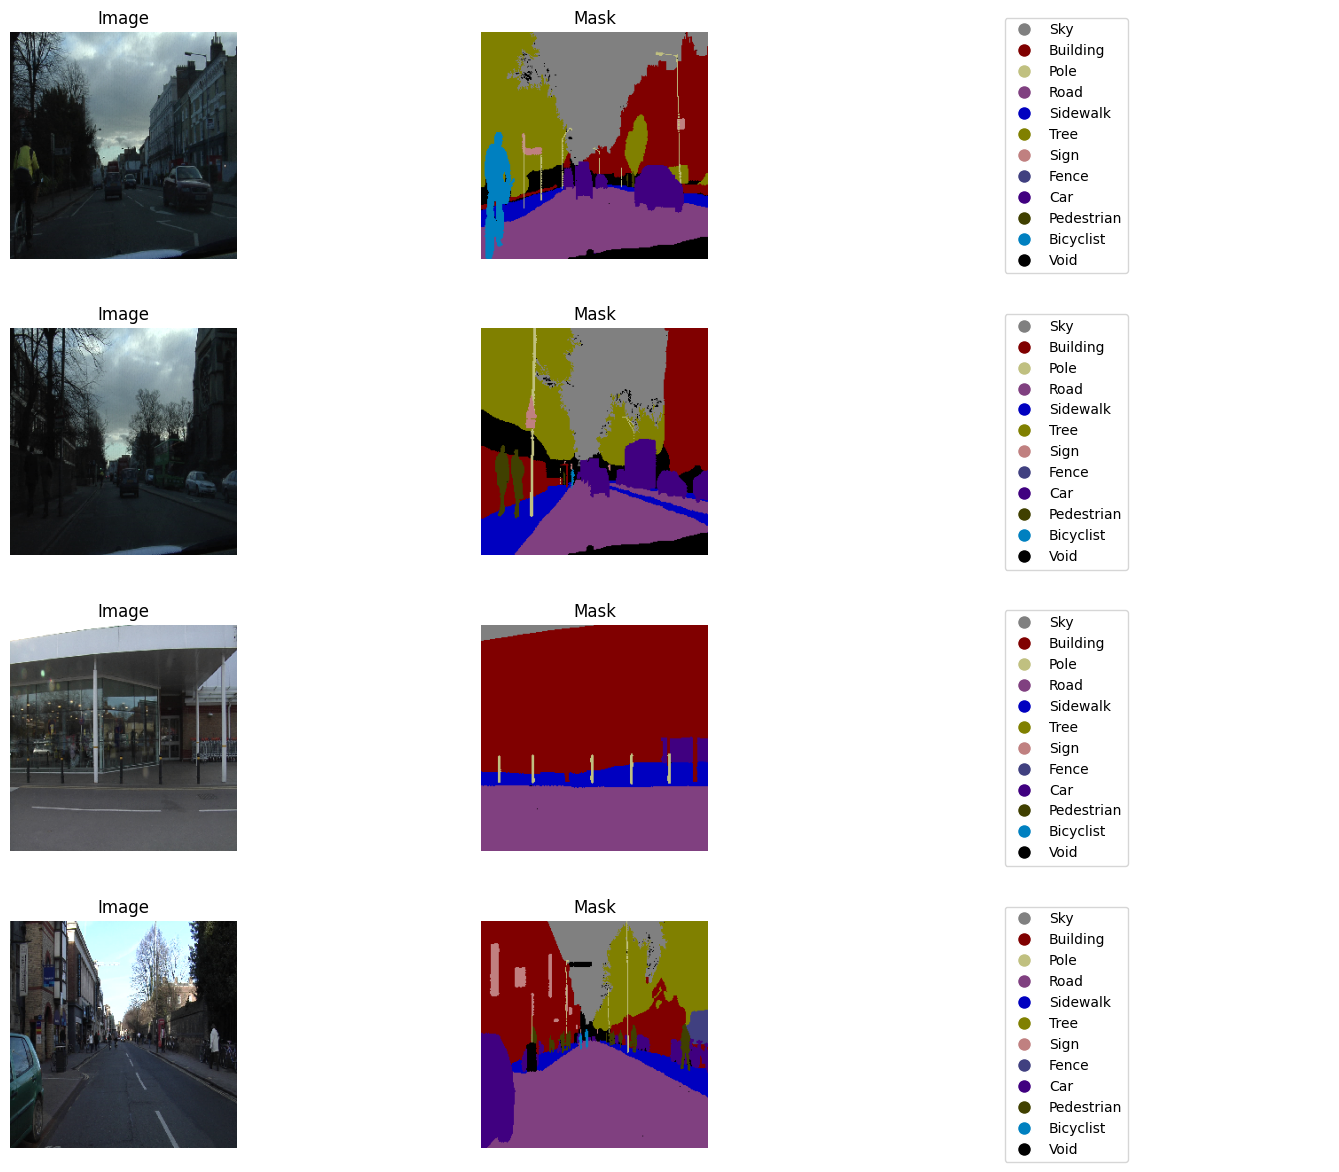

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mappa dei colori per le classi raggruppate
GROUPED_CLASS_COLORS = {
    'Sky': (128, 128, 128),
    'Building': (128, 0, 0),
    'Pole': (192, 192, 128),
    'Road': (128, 64, 128),
    'Sidewalk': (0, 0, 192),
    'Tree': (128, 128, 0),
    'Sign': (192, 128, 128),
    'Fence': (64, 64, 128),
    'Car': (64, 0, 128),
    'Pedestrian': (64, 64, 0),
    'Bicyclist': (0, 128, 192),
    'Void': (0,0,0)
}

# Funzione per convertire le etichette raggruppate in colori
def convert_grouped_labels_to_colors(grouped_labels, group_colors):
    color_labels = np.zeros(grouped_labels.shape + (3,), dtype=np.uint8)
    for group_index, group_name in enumerate(GROUPED_CLASS_COLORS.keys()):
        color = GROUPED_CLASS_COLORS[group_name]
        color_labels[grouped_labels == group_index] = color
    return color_labels

# Funzione per plottare immagini e maschere
def plot_images_and_masks(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))  # 3 colonne per immagini, maschere e legenda
    for i in range(num_samples):
        ax1, ax2, ax3 = axes[i]
        # Visualizza l'immagine
        ax1.imshow(images[i])
        ax1.set_title('Image')
        ax1.axis('off')

        # Converti la maschera in colori
        mask_colors = convert_grouped_labels_to_colors(masks[i], GROUPED_CLASS_COLORS)

        # Visualizza la maschera corrispondente
        ax2.imshow(mask_colors)
        ax2.set_title('Mask')
        ax2.axis('off')

        # Aggiungi una legenda per le classi raggruppate
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color) / 255, markersize=10)
                   for color in GROUPED_CLASS_COLORS.values()]
        labels = list(GROUPED_CLASS_COLORS.keys())
        ax3.legend(handles, labels, loc='center')
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Estrai un batch casuale di dati
x, y = next(iter(train_gen))  # Prende il primo batch; per semplicità, non necessariamente casuale

# Seleziona 4 campioni casuali dall'batch
indices = np.random.choice(x.shape[0], 4, replace=False)
selected_images = x[indices]
selected_masks = y[indices]

# Chiama la funzione per plottare
plot_images_and_masks(selected_images, selected_masks, num_samples=4)


Processing masks: 100%|██████████| 448/448 [09:57<00:00,  1.33s/it]


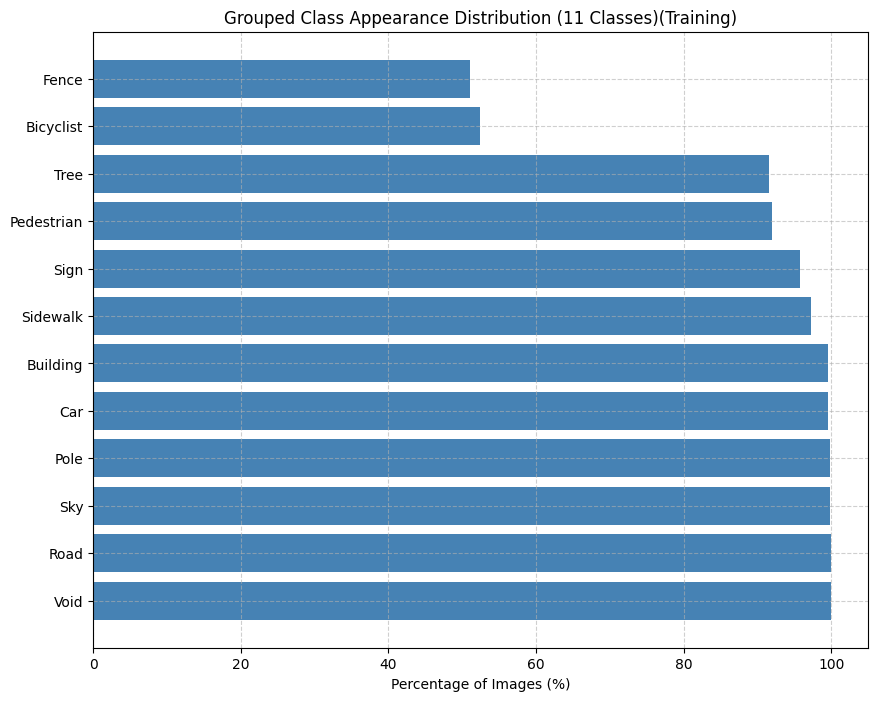

Grouped Class Appearance: defaultdict(<class 'int'>, {'Void': 448, 'Sidewalk': 436, 'Sign': 429, 'Bicyclist': 235, 'Car': 446, 'Pedestrian': 412, 'Building': 446, 'Road': 448, 'Sky': 447, 'Pole': 447, 'Fence': 229, 'Tree': 410})
Grouped Class Appearance Percentage: {'Void': 100.0, 'Sidewalk': 97.32142857142857, 'Sign': 95.75892857142857, 'Bicyclist': 52.45535714285714, 'Car': 99.55357142857143, 'Pedestrian': 91.96428571428571, 'Building': 99.55357142857143, 'Road': 100.0, 'Sky': 99.77678571428571, 'Pole': 99.77678571428571, 'Fence': 51.11607142857143, 'Tree': 91.51785714285714}
Total Images: 448


In [8]:
from collections import defaultdict
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Reverse the CAMVID_CLASSES dictionary for quick lookup
rgb_to_class = {v: k for k, v in CAMVID_CLASSES.items()}

# Create a new dictionary to store the grouped class appearance counts
grouped_class_appearance = defaultdict(int)

train_masks_cv  = [img_to_array(load_img(path)) for path in train_masks]


# Load the masks (Assuming 'labels' variable contains the masks)
from tqdm import tqdm

# Process each mask
for mask in tqdm(train_masks_cv, desc="Processing masks"):
    mask_int = mask.astype(int)
    unique_colors = np.unique(mask_int.reshape(-1, 3), axis=0)

    # Create a set to track which grouped classes have been counted for this mask
    counted_groups = set()

    # Check each unique color
    for color in unique_colors:
        class_name = rgb_to_class.get(tuple(color), None)
        if class_name:
            # Find which grouped class this class_name belongs to
            for grouped_class, members in CAMVID_CLASSES_GROUPED.items():
                if class_name in members and grouped_class not in counted_groups:
                    grouped_class_appearance[grouped_class] += 1
                    counted_groups.add(grouped_class)
                    break

# Calculate the total number of masks
total_images = len(train_masks_cv)

# Calculate the relative frequency as a percentage
grouped_class_appearance_percentage = {k: (v / total_images) * 100 for k, v in grouped_class_appearance.items()}

# Sort the grouped classes by appearance
sorted_grouped_classes = sorted(grouped_class_appearance_percentage, key=grouped_class_appearance_percentage.get, reverse=True)
sorted_grouped_percentages = [grouped_class_appearance_percentage[cls] for cls in sorted_grouped_classes]

# Plot the grouped class appearance distribution
plt.figure(figsize=(10, 8))
plt.barh(sorted_grouped_classes, sorted_grouped_percentages, color='steelblue')
plt.xlabel('Percentage of Images (%)')
plt.title('Grouped Class Appearance Distribution (11 Classes)(Training)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print results
print("Grouped Class Appearance:", grouped_class_appearance)
print("Grouped Class Appearance Percentage:", grouped_class_appearance_percentage)
print("Total Images:", total_images)

Processing masks: 100%|██████████| 112/112 [02:29<00:00,  1.33s/it]


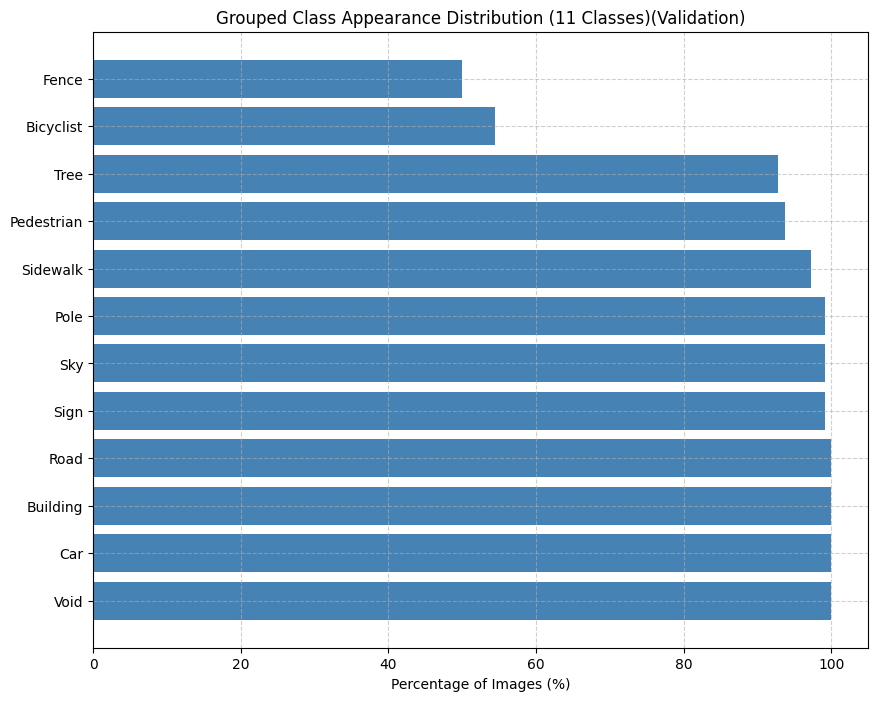

Grouped Class Appearance: defaultdict(<class 'int'>, {'Void': 112, 'Sidewalk': 109, 'Sign': 111, 'Car': 112, 'Pedestrian': 105, 'Building': 112, 'Road': 112, 'Tree': 104, 'Sky': 111, 'Pole': 111, 'Bicyclist': 61, 'Fence': 56})
Grouped Class Appearance Percentage: {'Void': 100.0, 'Sidewalk': 97.32142857142857, 'Sign': 99.10714285714286, 'Car': 100.0, 'Pedestrian': 93.75, 'Building': 100.0, 'Road': 100.0, 'Tree': 92.85714285714286, 'Sky': 99.10714285714286, 'Pole': 99.10714285714286, 'Bicyclist': 54.46428571428571, 'Fence': 50.0}
Total Images: 112


In [9]:
from collections import defaultdict
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Reverse the CAMVID_CLASSES dictionary for quick lookup
rgb_to_class = {v: k for k, v in CAMVID_CLASSES.items()}

# Create a new dictionary to store the grouped class appearance counts
grouped_class_appearance = defaultdict(int)

val_masks_cv  = [img_to_array(load_img(path)) for path in val_masks]


# Load the masks (Assuming 'labels' variable contains the masks)
from tqdm import tqdm

# Process each mask
for mask in tqdm(val_masks_cv, desc="Processing masks"):
    mask_int = mask.astype(int)
    unique_colors = np.unique(mask_int.reshape(-1, 3), axis=0)

    # Create a set to track which grouped classes have been counted for this mask
    counted_groups = set()

    # Check each unique color
    for color in unique_colors:
        class_name = rgb_to_class.get(tuple(color), None)
        if class_name:
            # Find which grouped class this class_name belongs to
            for grouped_class, members in CAMVID_CLASSES_GROUPED.items():
                if class_name in members and grouped_class not in counted_groups:
                    grouped_class_appearance[grouped_class] += 1
                    counted_groups.add(grouped_class)
                    break

# Calculate the total number of masks
total_images = len(val_masks_cv)

# Calculate the relative frequency as a percentage
grouped_class_appearance_percentage = {k: (v / total_images) * 100 for k, v in grouped_class_appearance.items()}

# Sort the grouped classes by appearance
sorted_grouped_classes = sorted(grouped_class_appearance_percentage, key=grouped_class_appearance_percentage.get, reverse=True)
sorted_grouped_percentages = [grouped_class_appearance_percentage[cls] for cls in sorted_grouped_classes]

# Plot the grouped class appearance distribution
plt.figure(figsize=(10, 8))
plt.barh(sorted_grouped_classes, sorted_grouped_percentages, color='steelblue')
plt.xlabel('Percentage of Images (%)')
plt.title('Grouped Class Appearance Distribution (11 Classes)(Validation)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print results
print("Grouped Class Appearance:", grouped_class_appearance)
print("Grouped Class Appearance Percentage:", grouped_class_appearance_percentage)
print("Total Images:", total_images)

Processing masks: 100%|██████████| 141/141 [03:04<00:00,  1.31s/it]


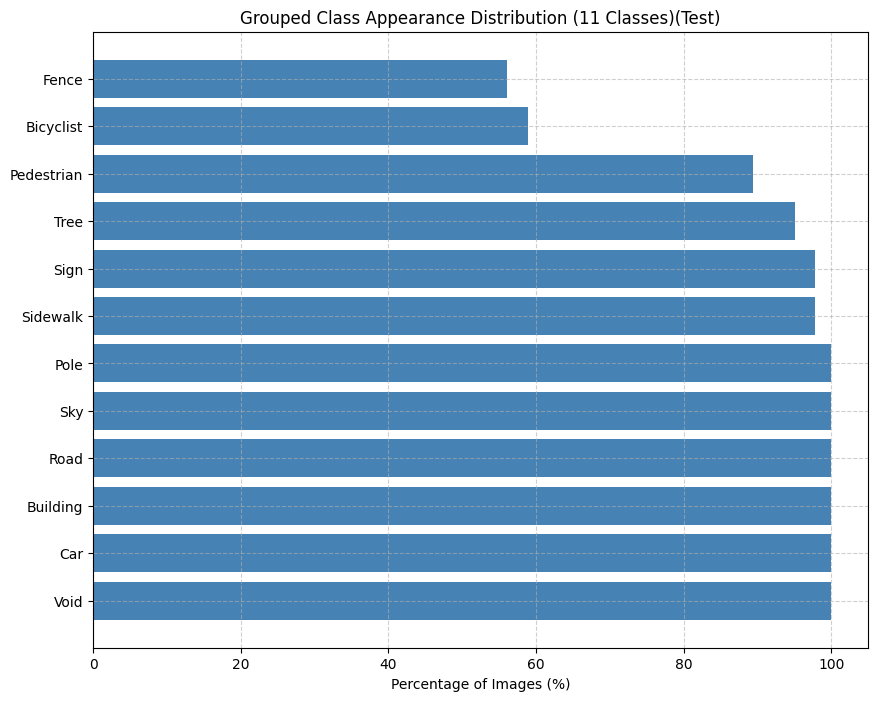

Grouped Class Appearance: defaultdict(<class 'int'>, {'Void': 141, 'Sidewalk': 138, 'Sign': 138, 'Bicyclist': 83, 'Car': 141, 'Pedestrian': 126, 'Fence': 79, 'Building': 141, 'Road': 141, 'Tree': 134, 'Sky': 141, 'Pole': 141})
Grouped Class Appearance Percentage: {'Void': 100.0, 'Sidewalk': 97.87234042553192, 'Sign': 97.87234042553192, 'Bicyclist': 58.86524822695035, 'Car': 100.0, 'Pedestrian': 89.36170212765957, 'Fence': 56.02836879432624, 'Building': 100.0, 'Road': 100.0, 'Tree': 95.0354609929078, 'Sky': 100.0, 'Pole': 100.0}
Total Images: 141


In [10]:
from collections import defaultdict
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Reverse the CAMVID_CLASSES dictionary for quick lookup
rgb_to_class = {v: k for k, v in CAMVID_CLASSES.items()}

# Create a new dictionary to store the grouped class appearance counts
grouped_class_appearance = defaultdict(int)

test_masks = [os.path.join('data/processed/test/labels', fname) for fname in os.listdir('data/processed/test/labels')]

test_masks_cv  = [img_to_array(load_img(path)) for path in test_masks]

# Load the masks (Assuming 'labels' variable contains the masks)
from tqdm import tqdm

# Process each mask
for mask in tqdm(test_masks_cv, desc="Processing masks"):
    mask_int = mask.astype(int)
    unique_colors = np.unique(mask_int.reshape(-1, 3), axis=0)

    # Create a set to track which grouped classes have been counted for this mask
    counted_groups = set()

    # Check each unique color
    for color in unique_colors:
        class_name = rgb_to_class.get(tuple(color), None)
        if class_name:
            # Find which grouped class this class_name belongs to
            for grouped_class, members in CAMVID_CLASSES_GROUPED.items():
                if class_name in members and grouped_class not in counted_groups:
                    grouped_class_appearance[grouped_class] += 1
                    counted_groups.add(grouped_class)
                    break

# Calculate the total number of masks
total_images = len(test_masks_cv)

# Calculate the relative frequency as a percentage
grouped_class_appearance_percentage = {k: (v / total_images) * 100 for k, v in grouped_class_appearance.items()}

# Sort the grouped classes by appearance
sorted_grouped_classes = sorted(grouped_class_appearance_percentage, key=grouped_class_appearance_percentage.get, reverse=True)
sorted_grouped_percentages = [grouped_class_appearance_percentage[cls] for cls in sorted_grouped_classes]

# Plot the grouped class appearance distribution
plt.figure(figsize=(10, 8))
plt.barh(sorted_grouped_classes, sorted_grouped_percentages, color='steelblue')
plt.xlabel('Percentage of Images (%)')
plt.title('Grouped Class Appearance Distribution (11 Classes)(Test)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print results
print("Grouped Class Appearance:", grouped_class_appearance)
print("Grouped Class Appearance Percentage:", grouped_class_appearance_percentage)
print("Total Images:", total_images)

# Metrics Definition

In [ ]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None, ignore_class=None, sparse_y_true=True, sparse_y_pred=True, axis=-1):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.ignore_class = ignore_class
        self.sparse_y_true = sparse_y_true
        self.sparse_y_pred = sparse_y_pred
        self.axis = axis

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert y_true and y_pred to int32
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.argmax(y_pred, axis=self.axis)
        y_pred = tf.cast(y_pred, tf.int32)

        # Mask out ignore class
        if self.ignore_class is not None:
            ignore_mask = tf.not_equal(y_true, self.ignore_class)
            y_true = tf.boolean_mask(y_true, ignore_mask)
            y_pred = tf.boolean_mask(y_pred, ignore_mask)

        # Compute metric
        return super().update_state(y_true, y_pred, sample_weight)


# Istanziamento della metrica con la classe "Void" ignorata
ignore_class_index = list(CAMVID_CLASSES_GROUPED.keys()).index('Void')
mean_iou_metric = CustomMeanIoU(num_classes=num_classes, ignore_class=ignore_class_index, name='custom_mean_io_u')


# Results utils functions

In [ ]:
def plot_training_results(log_path, model_name):
    # Caricare i log dell'allenamento dal file CSV
    logs = pd.read_csv(log_path)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.plot(logs['accuracy'])
    plt.plot(logs['val_accuracy'])
    plt.title(f'Model Accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(logs['loss'])
    plt.plot(logs['val_loss'])
    plt.title(f'Model Loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation Mean IoU values
    plt.figure(figsize=(12, 6))
    plt.plot(logs['custom_mean_io_u'])
    plt.plot(logs['val_custom_mean_io_u'])
    plt.title(f'Model Mean IoU - {model_name}')
    plt.ylabel('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylim(0, 0.8)  # Set y-axis limit for Mean IoU
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
selected_indices = None


In [ ]:
# Creazione della mappa dei colori
class_colors = np.array(list(GROUPED_CLASS_COLORS.values()))

def plot_predictions(model, data_generator, num_samples=5, indices=None):
    global selected_indices

    # Ottenere il numero di batch
    num_batches = len(data_generator)

    # Pescare un batch di immagini dal generatore
    x, y_true = data_generator[2]

    # Selezionare casualmente num_samples indici la prima volta
    if selected_indices is None:
        selected_indices = np.random.choice(x.shape[0], num_samples, replace=False)

    # Effettuare predizioni con il modello
    y_pred = model.predict(x)

    # Funzione per mappare le maschere ai colori
    def colorize_mask(mask):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for i in range(len(class_colors)):
            color_mask[mask == i] = class_colors[i]
        return color_mask

    # Creare i plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i, idx in enumerate(selected_indices):
        # Immagine originale
        axes[i, 0].imshow(x[idx])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Maschera vera
        true_mask_colored = colorize_mask(np.squeeze(y_true[idx]))
        axes[i, 1].imshow(true_mask_colored)
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')

        # Maschera predetta
        pred_mask = np.argmax(y_pred[idx], axis=-1)
        pred_mask_colored = colorize_mask(pred_mask)
        axes[i, 2].imshow(pred_mask_colored)
        axes[i, 2].set_title(f'Predicted Mask - {model.name}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

class AugmentedCamVidDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, class_colors, batch_size=16, target_size=(256, 256), augmentations=None, class_mapping=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.class_colors = class_colors
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.class_mapping = class_mapping

        self.image_datagen = ImageDataGenerator(**augmentations) if augmentations else ImageDataGenerator()
        self.mask_datagen = ImageDataGenerator(**augmentations) if augmentations else ImageDataGenerator()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i: i + self.batch_size]
        batch_mask_paths = self.mask_paths[i: i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.target_size + (3,), dtype='float32')
        y = np.zeros((self.batch_size,) + self.target_size, dtype='int32')  # 2D labels

        for j, (image_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            img = load_img(image_path, target_size=self.target_size)
            mask = load_img(mask_path, target_size=self.target_size, color_mode='rgb')

            img = img_to_array(img)
            mask = img_to_array(mask)

            mask = self.form_2D_label(mask)

            x[j] = img / 255.0
            y[j] = mask  # assign 2D labels

        # Augmenting images and masks together
        seed = np.random.randint(0, 10000)
        x_augmented = self.image_datagen.flow(x, batch_size=self.batch_size, seed=seed, shuffle=False)
        y_augmented = self.mask_datagen.flow(np.expand_dims(y, axis=-1), batch_size=self.batch_size, seed=seed, shuffle=False)

        return next(x_augmented), np.squeeze(next(y_augmented), axis=-1)

    def form_2D_label(self, mask):
        label = np.zeros(mask.shape[:2], dtype=np.uint8)
        for i, rgb in enumerate(self.class_colors):
            label[(mask == rgb).all(axis=-1)] = i

        # Convert labels to grouped labels if class mapping is provided
        if self.class_mapping:
            label = convert_labels_to_grouped(label, self.class_mapping)

        return label

# Parametri di augmentazione
data_gen_args = dict(
    horizontal_flip=True
)

# Creazione del generatore
train_aug_gen = AugmentedCamVidDataGenerator(
    train_images, train_masks, list(CAMVID_CLASSES.values()),
    batch_size=16, target_size=(256, 256), augmentations=data_gen_args,
    class_mapping=CAMVID_CLASSES_TO_GROUP
)



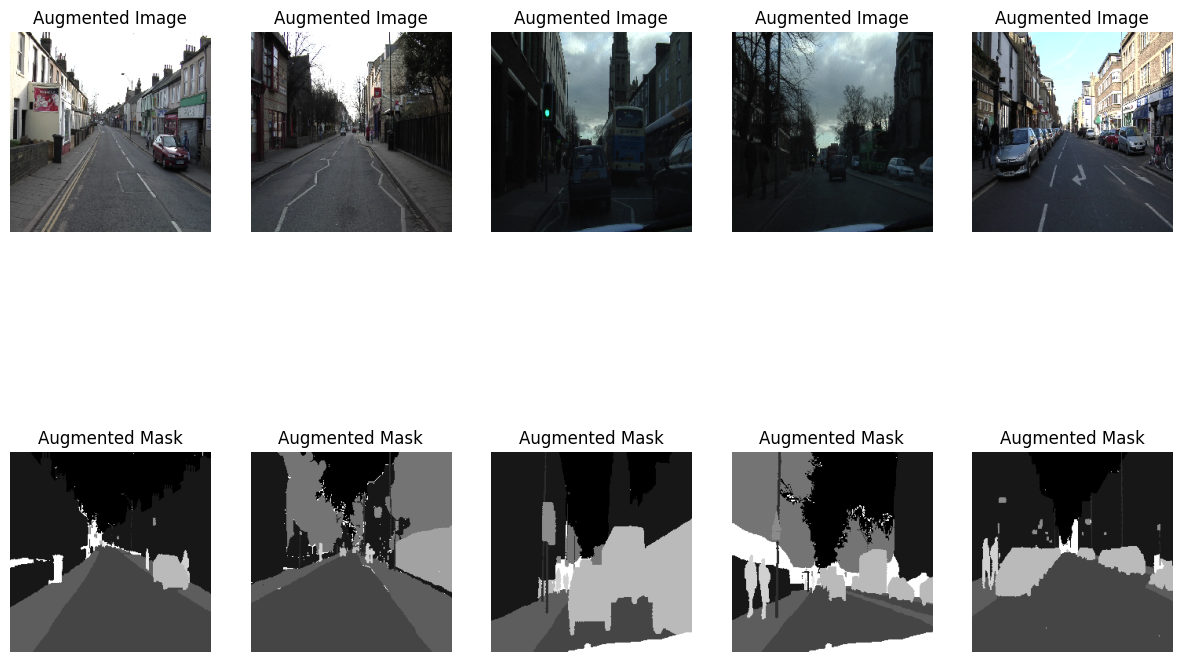

In [ ]:
# Estrarre il primo batch dal generatore
x_augmented, y_augmented = train_aug_gen[0]

# Funzione per visualizzare le immagini e le loro maschere
def display_augmented_images(images, masks, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Immagini originali augmentate
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        plt.title('Augmented Image')
        plt.axis('off')

        # Maschere corrispondenti
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Augmented Mask')
        plt.axis('off')
    plt.show()

# Visualizzare 5 immagini augmentate e le loro maschere
display_augmented_images(x_augmented, y_augmented, num_images=5)

# Training

## Training Utils

In [ ]:
def train_or_resume_model(model, augmentation = False):

  model_name = model.name
  model_folder = os.path.join(models_path, model_name)
  os.makedirs(model_folder, exist_ok = True)

  checkpoint_path = os.path.join(model_folder, f'{model_name}.keras')
  log_path = os.path.join(model_folder, f'{model_name}_log.csv')
  if os.path.exists(log_path):
        append_logs = True
  else:
        append_logs = False
  if os.path.exists(checkpoint_path):
    print("Caricamento del modello dal checkpoint...")
    model = load_model(checkpoint_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=num_classes, ignore_class=ignore_class_index, name='custom_mean_io_u')})
  else:
    model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', CustomMeanIoU(num_classes=num_classes, ignore_class=ignore_class_index, name='custom_mean_io_u')])

  callbacks = [
    EarlyStopping(patience=20, verbose=1, monitor='val_custom_mean_io_u', mode='max'),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_custom_mean_io_u', mode='max', save_weights_only=False),
    CSVLogger(log_path, append = append_logs),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)

  ]

  if augmentation:
    history = model.fit(train_aug_gen,
                        epochs=50,
                        validation_data=val_gen,
                        callbacks=callbacks)
  else:
    # Addestramento del modello
    history = model.fit(train_gen,
                        epochs=50,
                        validation_data=val_gen,
                        callbacks=callbacks)

  return history




## Second Model

In [ ]:
model_name = 'second_model'

In [ ]:
def build_unet_v2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    # Core
    c = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(c)
    u3 = layers.concatenate([u3, x3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u3)
    u2 = layers.concatenate([u2, x2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(u2)
    u1 = layers.concatenate([u1, x1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name='second_model')
    return model

# Instanziare il modello
input_shape = (256, 256, 3)
model = build_unet_v2(input_shape=input_shape, num_classes=num_classes)

history = train_or_resume_model(model)


Caricamento del modello dal checkpoint...
Epoch 1/50
28/28 [==============================] - 63s 2s/step - loss: 0.2538 - accuracy: 0.9186 - custom_mean_io_u: 0.6087 - val_loss: 0.4243 - val_accuracy: 0.8844 - val_custom_mean_io_u: 0.5320 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 58s 2s/step - loss: 0.2462 - accuracy: 0.9209 - custom_mean_io_u: 0.6180 - val_loss: 0.3759 - val_accuracy: 0.8911 - val_custom_mean_io_u: 0.5545 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 59s 2s/step - loss: 0.2345 - accuracy: 0.9244 - custom_mean_io_u: 0.6251 - val_loss: 0.3773 - val_accuracy: 0.8931 - val_custom_mean_io_u: 0.5592 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 58s 2s/step - loss: 0.2230 - accuracy: 0.9280 - custom_mean_io_u: 0.6376 - val_loss: 0.3948 - val_accuracy: 0.8904 - val_custom_mean_io_u: 0.5495 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 58s 2s/step - loss: 0.2180 - accuracy: 0.9298 - custom_mean_io

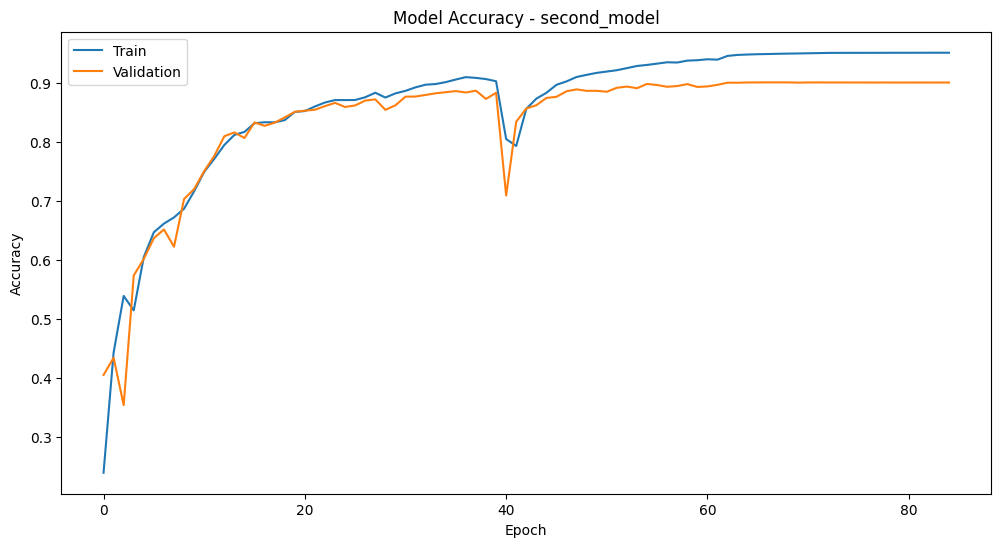

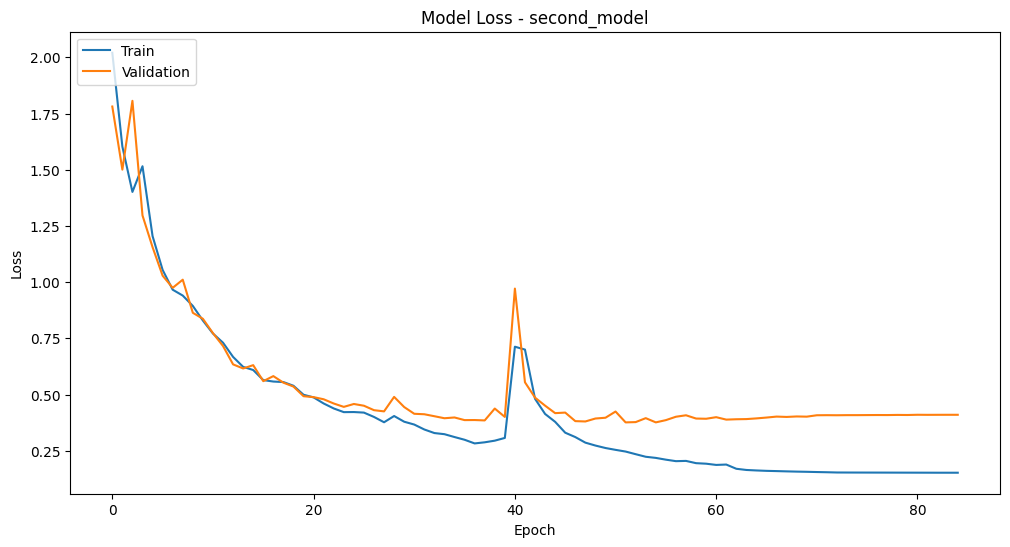

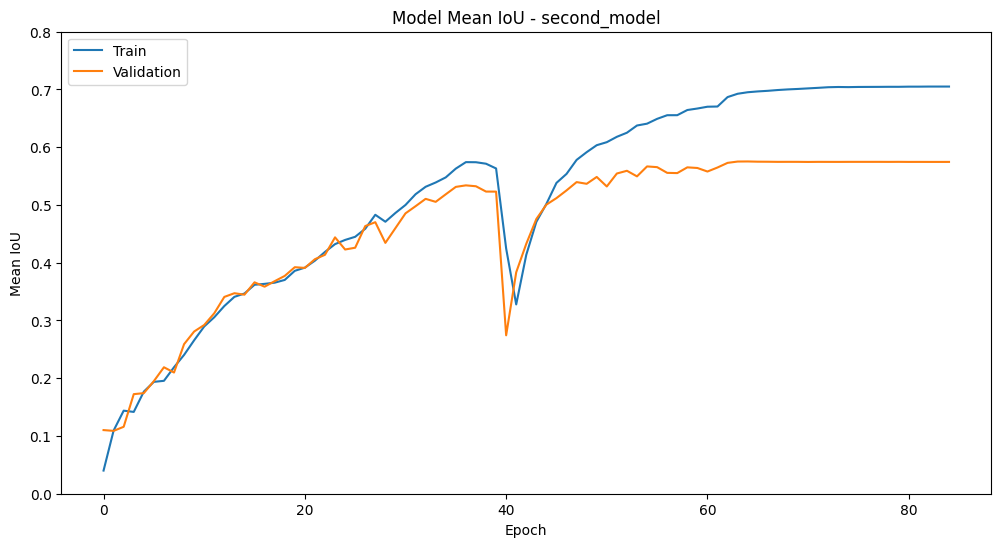

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  second_model
Total params: 2141004
Trainable params: 2141004
Non-trainable params: 0.0


## Third Model

In [ ]:
model_name = 'third_model'

In [ ]:
def build_unet_v3(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)

    # Core
    c = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(c)
    u4 = layers.concatenate([u4, x4])
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(u4)
    u3 = layers.concatenate([u3, x3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u3)
    u2 = layers.concatenate([u2, x2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(u2)
    u1 = layers.concatenate([u1, x1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name=model_name)
    return model

# Model instantiation
model = build_unet_v3(input_shape=(256, 256, 3), num_classes=num_classes)

history = train_or_resume_model(model)

Caricamento del modello dal checkpoint...
Epoch 1/50
28/28 [==============================] - 97s 2s/step - loss: 0.3059 - accuracy: 0.9032 - custom_mean_io_u: 0.5508 - val_loss: 0.3812 - val_accuracy: 0.8870 - val_custom_mean_io_u: 0.5380 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 57s 2s/step - loss: 0.2924 - accuracy: 0.9073 - custom_mean_io_u: 0.5637 - val_loss: 0.3763 - val_accuracy: 0.8886 - val_custom_mean_io_u: 0.5330 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 60s 2s/step - loss: 0.2735 - accuracy: 0.9127 - custom_mean_io_u: 0.5815 - val_loss: 0.3790 - val_accuracy: 0.8920 - val_custom_mean_io_u: 0.5428 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 60s 2s/step - loss: 0.2683 - accuracy: 0.9139 - custom_mean_io_u: 0.5866 - val_loss: 0.3595 - val_accuracy: 0.8957 - val_custom_mean_io_u: 0.5569 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 58s 2s/step - loss: 0.2574 - accuracy: 0.9176 - custom_mean_io

KeyboardInterrupt: 

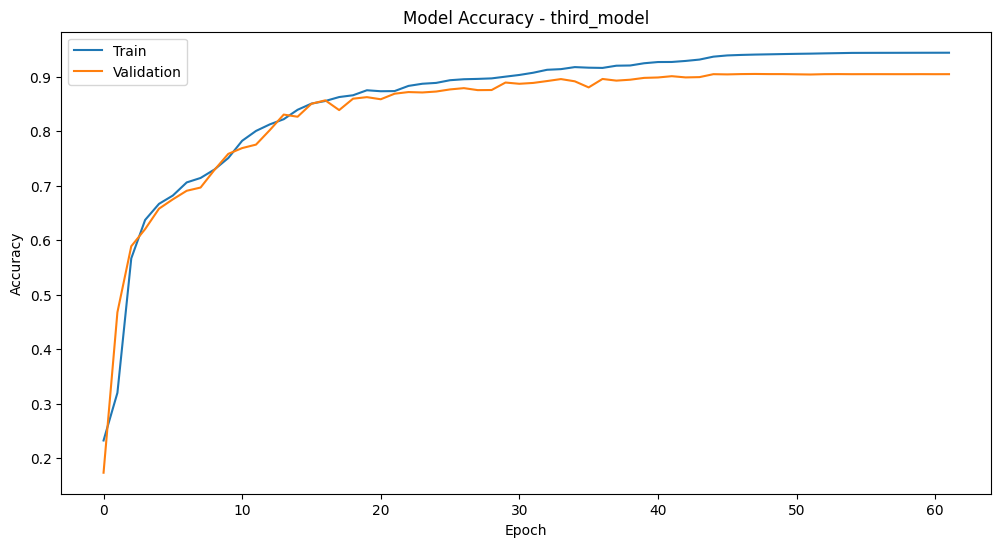

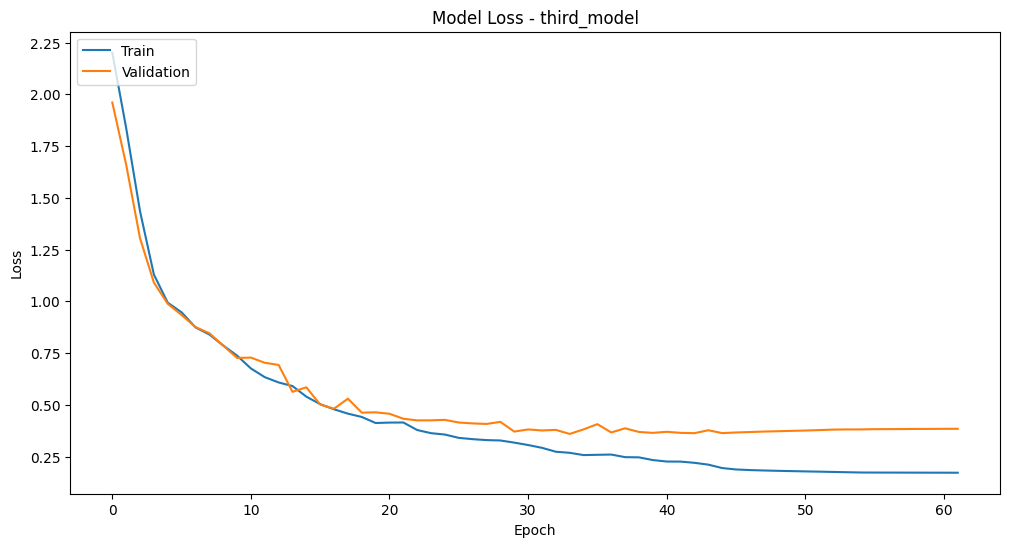

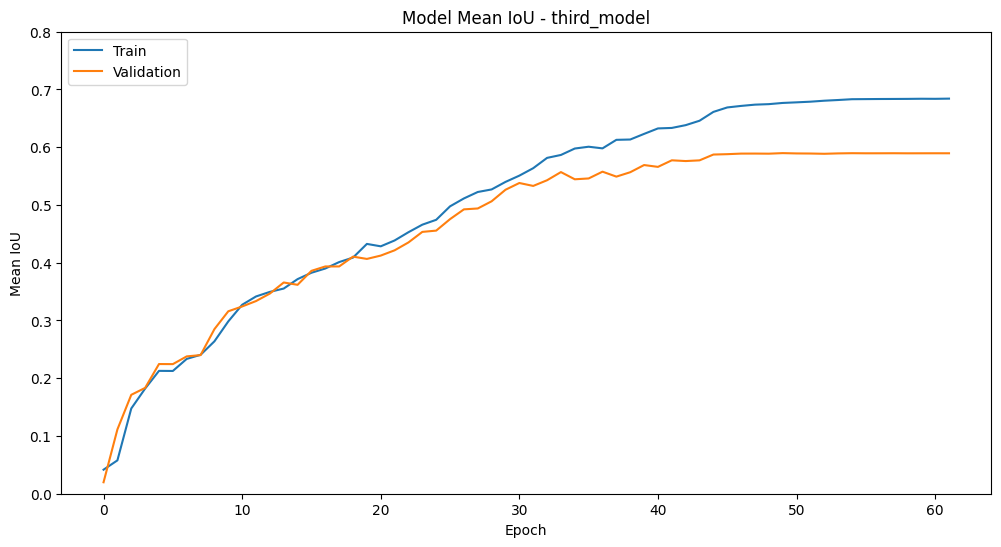

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  third_model
Total params: 8630860
Trainable params: 8630860
Non-trainable params: 0.0


##Fourh Model

In [ ]:
model_name = 'fourth_model'

In [ ]:
def build_unet_v4(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)

    x5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    x5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x5)
    p5 = layers.MaxPooling2D((2, 2))(x5)

    # Core
    c = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p5)
    c = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    u5 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same')(c)
    u5 = layers.concatenate([u5, x5])
    u5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u5)

    u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(u5)
    u4 = layers.concatenate([u4, x4])
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(u4)
    u3 = layers.concatenate([u3, x3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u3)
    u2 = layers.concatenate([u2, x2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(u2)
    u1 = layers.concatenate([u1, x1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name= model_name)
    return model

# Model instantiation
model = build_unet_v4(input_shape=(256, 256, 3), num_classes=num_classes)

history = train_or_resume_model(model)

Caricamento del modello dal checkpoint...
Epoch 1/50
28/28 [==============================] - 70s 2s/step - loss: 0.1974 - accuracy: 0.9358 - custom_mean_io_u: 0.6668 - val_loss: 0.3716 - val_accuracy: 0.9027 - val_custom_mean_io_u: 0.5867 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 61s 2s/step - loss: 0.1924 - accuracy: 0.9374 - custom_mean_io_u: 0.6726 - val_loss: 0.3777 - val_accuracy: 0.9028 - val_custom_mean_io_u: 0.5932 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 59s 2s/step - loss: 0.1883 - accuracy: 0.9388 - custom_mean_io_u: 0.6749 - val_loss: 0.3745 - val_accuracy: 0.9012 - val_custom_mean_io_u: 0.5883 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 59s 2s/step - loss: 0.1817 - accuracy: 0.9407 - custom_mean_io_u: 0.6810 - val_loss: 0.3705 - val_accuracy: 0.9043 - val_custom_mean_io_u: 0.5914 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 68s 2s/step - loss: 0.1773 - accuracy: 0.9421 - custom_mean_io

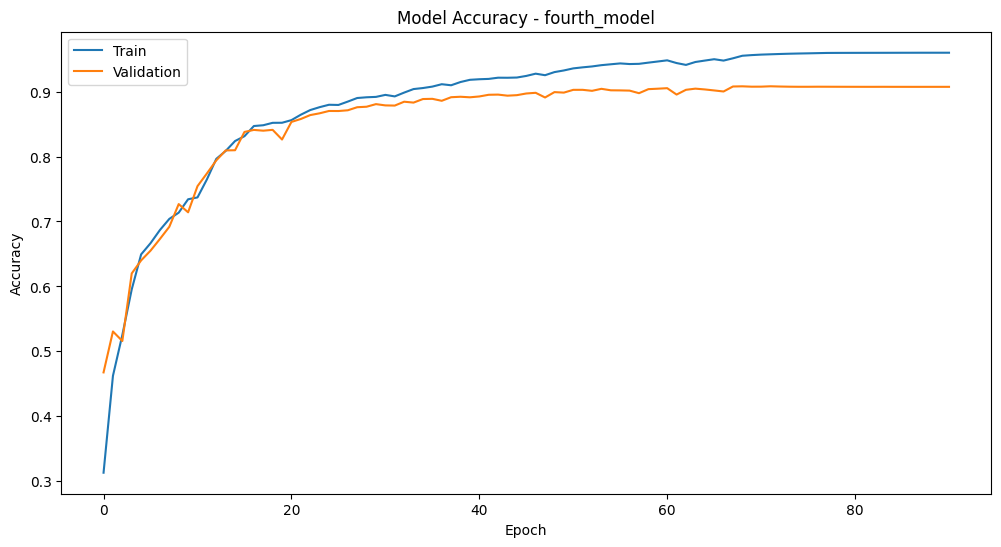

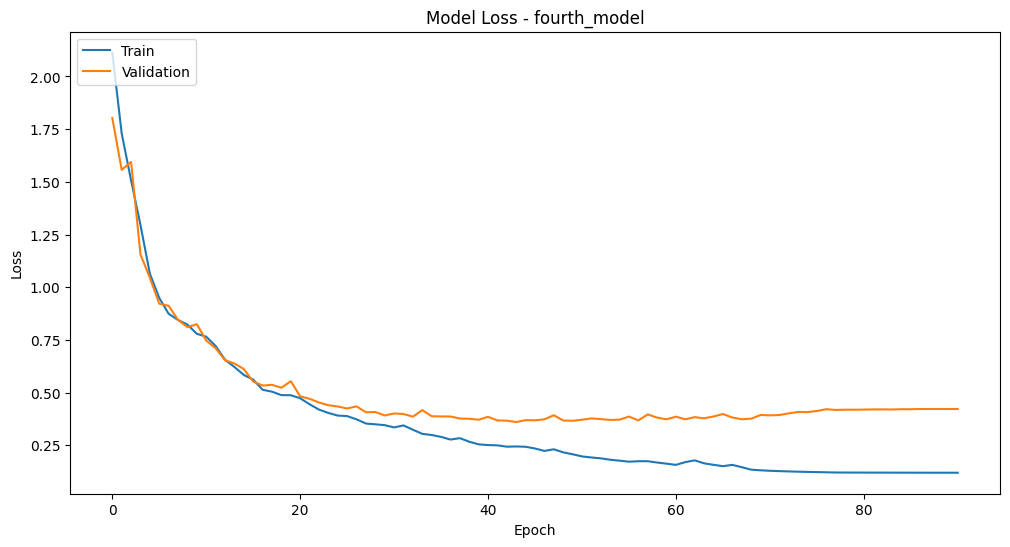

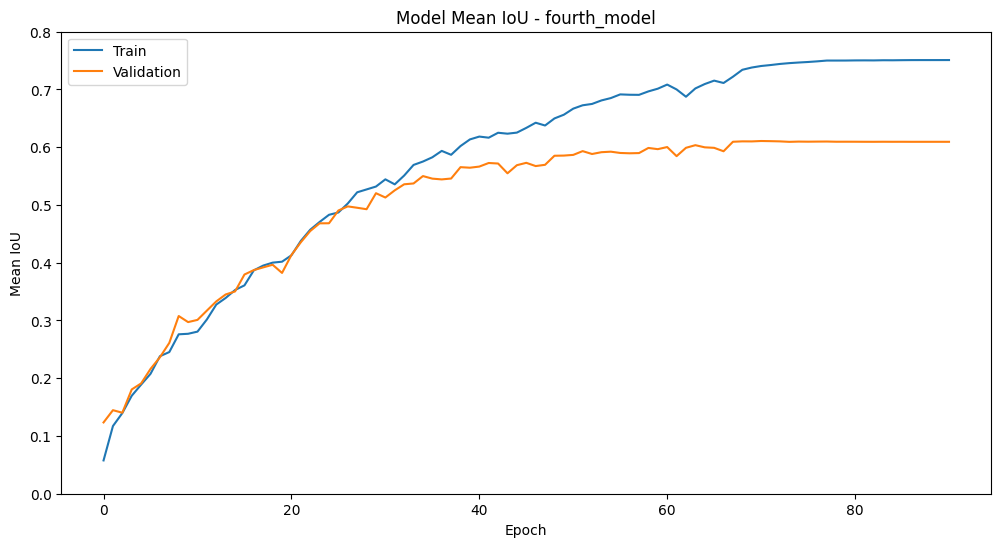

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  fourth_model
Total params: 34586700
Trainable params: 34586700
Non-trainable params: 0.0


## Fourth model with Attention

In [ ]:
model_name = 'fourth_model_attention'

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def attention_block(x, g, inter_channel):
    theta_x = layers.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    add_xg = layers.add([theta_x, phi_g])
    act_xg = layers.Activation('relu')(add_xg)
    psi = layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    mul_xg = layers.multiply([x, sigmoid_xg])
    return mul_xg

def build_unet_v4_with_attention(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)

    x5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    x5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x5)
    p5 = layers.MaxPooling2D((2, 2))(x5)

    # Core
    c = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p5)
    c = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c)

    # Decoder with attention modules
    u5 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same')(c)
    a5 = attention_block(x5, u5, 512)
    u5 = layers.concatenate([u5, a5])
    u5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u5)

    u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(u5)
    a4 = attention_block(x4, u4, 256)
    u4 = layers.concatenate([u4, a4])
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(u4)
    a3 = attention_block(x3, u3, 128)
    u3 = layers.concatenate([u3, a3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u3)
    a2 = attention_block(x2, u2, 64)
    u2 = layers.concatenate([u2, a2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(u2)
    a1 = attention_block(x1, u1, 32)
    u1 = layers.concatenate([u1, a1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name= model_name)
    return model

# Model instantiation
model = build_unet_v4_with_attention(input_shape=(256, 256, 3), num_classes=num_classes)

# Train or resume model
history = train_or_resume_model(model)


Epoch 1/50
28/28 [==============================] - 81s 2s/step - loss: 2.1204 - accuracy: 0.1803 - custom_mean_io_u: 0.0324 - val_loss: 1.9100 - val_accuracy: 0.1947 - val_custom_mean_io_u: 0.0255 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 63s 2s/step - loss: 1.7568 - accuracy: 0.3684 - custom_mean_io_u: 0.0661 - val_loss: 1.6246 - val_accuracy: 0.4362 - val_custom_mean_io_u: 0.0976 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 63s 2s/step - loss: 1.4367 - accuracy: 0.5337 - custom_mean_io_u: 0.1466 - val_loss: 1.6523 - val_accuracy: 0.4735 - val_custom_mean_io_u: 0.1319 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 63s 2s/step - loss: 1.2789 - accuracy: 0.5863 - custom_mean_io_u: 0.1699 - val_loss: 1.2297 - val_accuracy: 0.5909 - val_custom_mean_io_u: 0.1804 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 62s 2s/step - loss: 1.1565 - accuracy: 0.6158 - custom_mean_io_u: 0.1871 - val_loss: 1.1137 - val_accura

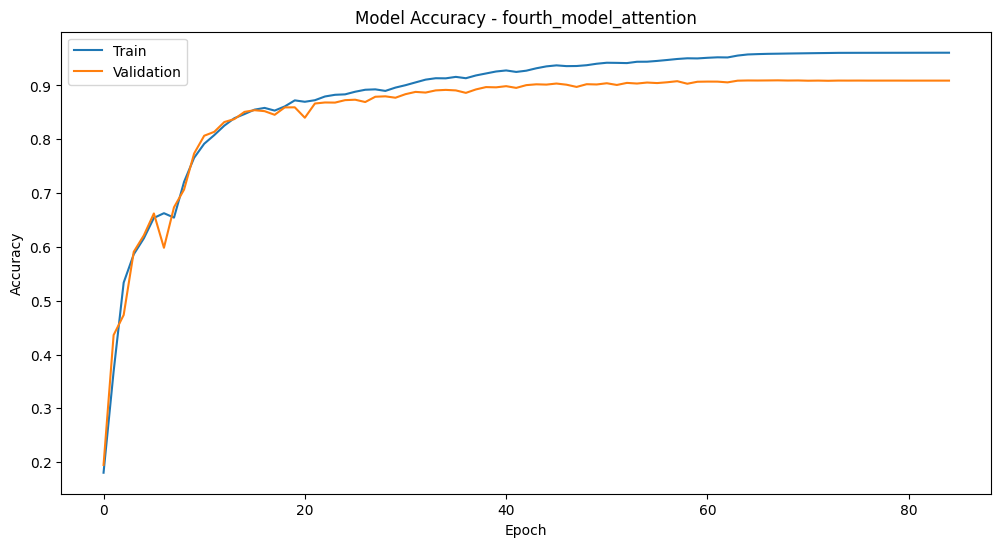

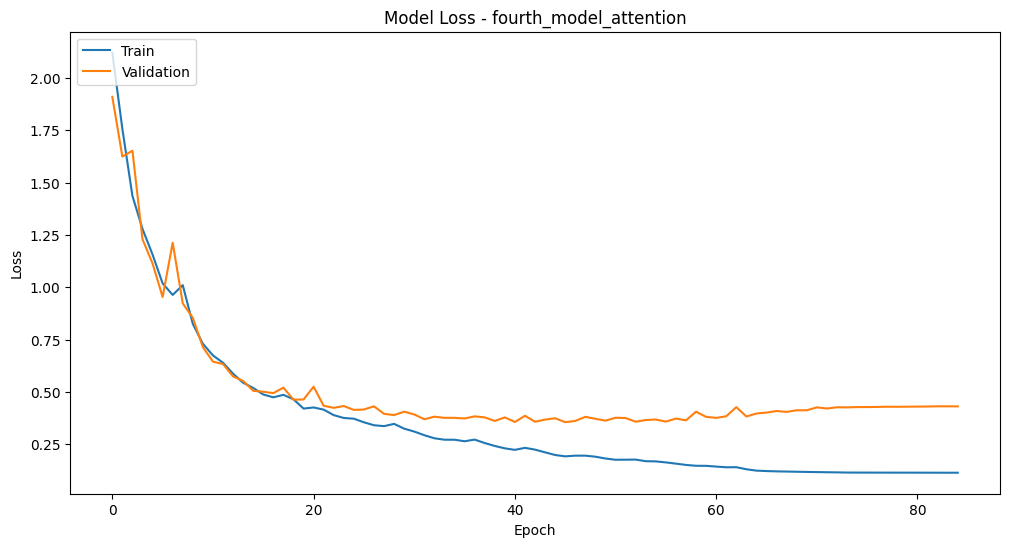

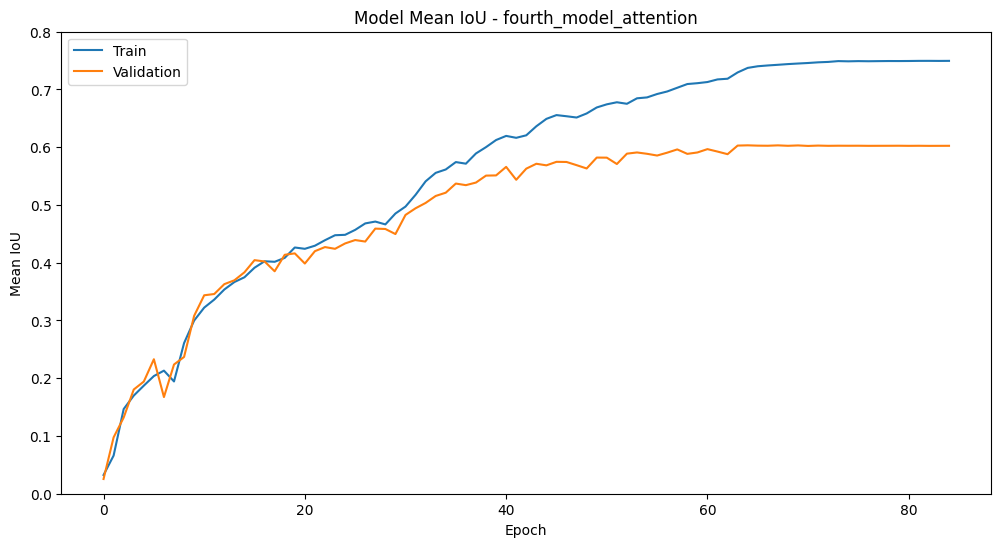

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  fourth_model_attention
Total params: 35288049
Trainable params: 35288049
Non-trainable params: 0.0


## Fifth Model

In [ ]:
model_name  = "fifth_model"

In [ ]:
from tensorflow.keras import layers, models

def build_unet_v5(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    x4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    x4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)

    x5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    x5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x5)
    p5 = layers.MaxPooling2D((2, 2))(x5)

    # Core
    c = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(p5)
    c = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    u5 = layers.Conv2DTranspose(1024, (3, 3), strides=2, activation='relu', padding='same')(c)
    u5 = layers.concatenate([u5, x5])
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)

    u4 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same')(u5)
    u4 = layers.concatenate([u4, x4])
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(u4)
    u3 = layers.concatenate([u3, x3])
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(u3)
    u2 = layers.concatenate([u2, x2])
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u2)
    u1 = layers.concatenate([u1, x1])
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name=model_name)
    return model

# Model instantiation
model = build_unet_v5(input_shape=(256, 256, 3), num_classes=num_classes)

history = train_or_resume_model(model)


Caricamento del modello dal checkpoint...
Epoch 1/50
28/28 [==============================] - 88s 3s/step - loss: 0.2122 - accuracy: 0.9304 - custom_mean_io_u: 0.6617 - val_loss: 0.3259 - val_accuracy: 0.9038 - val_custom_mean_io_u: 0.5960 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 94s 3s/step - loss: 0.2011 - accuracy: 0.9338 - custom_mean_io_u: 0.6728 - val_loss: 0.3247 - val_accuracy: 0.9069 - val_custom_mean_io_u: 0.5963 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 90s 3s/step - loss: 0.1905 - accuracy: 0.9370 - custom_mean_io_u: 0.6840 - val_loss: 0.3339 - val_accuracy: 0.9039 - val_custom_mean_io_u: 0.6041 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 69s 2s/step - loss: 0.1899 - accuracy: 0.9372 - custom_mean_io_u: 0.6853 - val_loss: 0.3376 - val_accuracy: 0.9046 - val_custom_mean_io_u: 0.6022 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 79s 3s/step - loss: 0.1914 - accuracy: 0.9367 - custom_mean_io

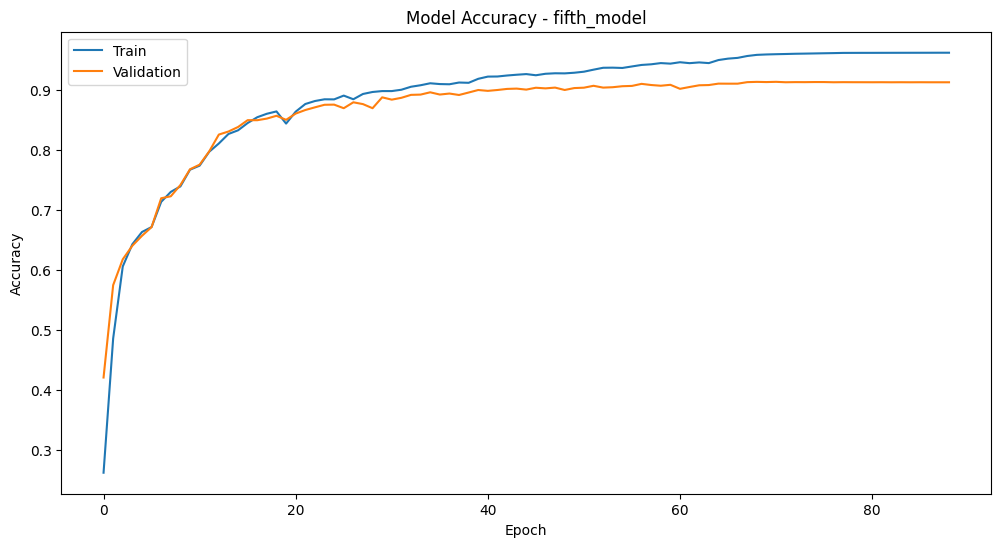

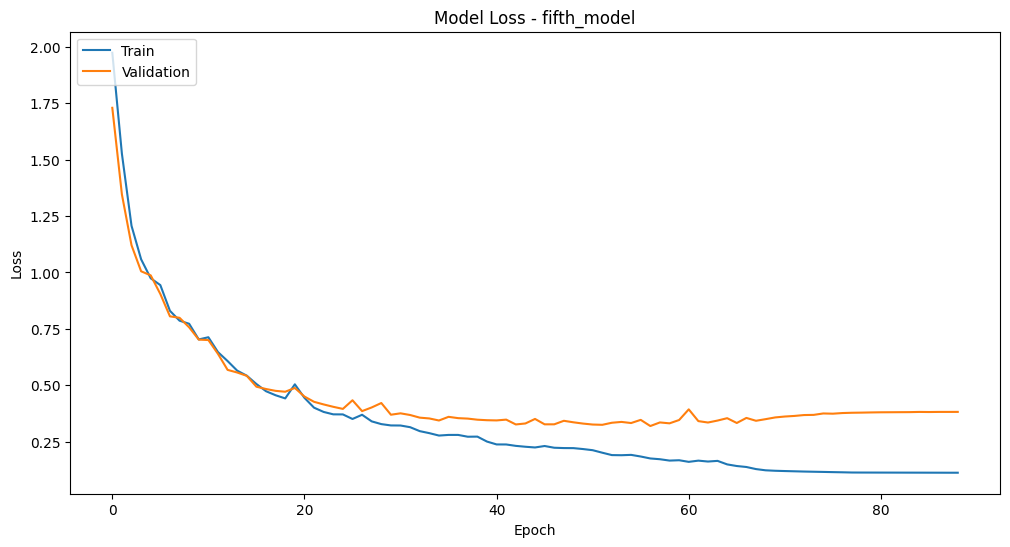

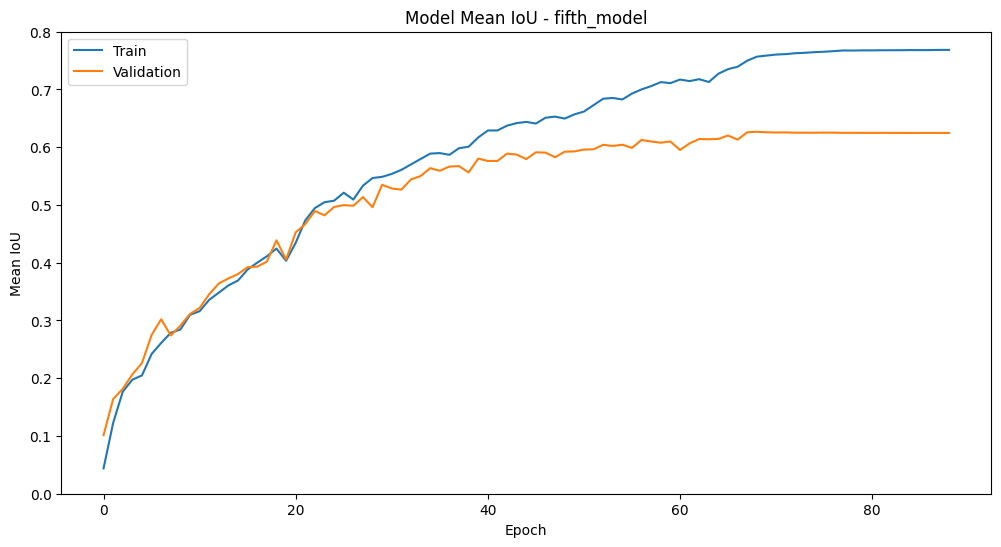

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  fifth_model
Total params: 138330252
Trainable params: 138330252
Non-trainable params: 0.0


##Fourth Model with Attention and Augmentation

In [ ]:
model_name = 'fourth_model_attention_augmented'

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def attention_block(x, g, inter_channel):
    theta_x = layers.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    add_xg = layers.add([theta_x, phi_g])
    act_xg = layers.Activation('relu')(add_xg)
    psi = layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    mul_xg = layers.multiply([x, sigmoid_xg])
    return mul_xg

def build_unet_v4_with_attention(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)

    x5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    x5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x5)
    p5 = layers.MaxPooling2D((2, 2))(x5)

    # Core
    c = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p5)
    c = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c)

    # Decoder with attention modules
    u5 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same')(c)
    a5 = attention_block(x5, u5, 512)
    u5 = layers.concatenate([u5, a5])
    u5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u5)

    u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(u5)
    a4 = attention_block(x4, u4, 256)
    u4 = layers.concatenate([u4, a4])
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(u4)
    a3 = attention_block(x3, u3, 128)
    u3 = layers.concatenate([u3, a3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u3)
    a2 = attention_block(x2, u2, 64)
    u2 = layers.concatenate([u2, a2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(u2)
    a1 = attention_block(x1, u1, 32)
    u1 = layers.concatenate([u1, a1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name= model_name)
    return model

# Model instantiation
model = build_unet_v4_with_attention(input_shape=(256, 256, 3), num_classes=num_classes)

# Train or resume model
history = train_or_resume_model(model, augmentation = True)


Caricamento del modello dal checkpoint...
Epoch 1/50
28/28 [==============================] - 74s 2s/step - loss: 0.2690 - accuracy: 0.9140 - custom_mean_io_u: 0.5819 - val_loss: 0.3655 - val_accuracy: 0.8908 - val_custom_mean_io_u: 0.5294 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 73s 3s/step - loss: 0.2653 - accuracy: 0.9153 - custom_mean_io_u: 0.5842 - val_loss: 0.3630 - val_accuracy: 0.8939 - val_custom_mean_io_u: 0.5384 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 63s 2s/step - loss: 0.2600 - accuracy: 0.9169 - custom_mean_io_u: 0.5893 - val_loss: 0.3670 - val_accuracy: 0.8917 - val_custom_mean_io_u: 0.5457 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 61s 2s/step - loss: 0.2473 - accuracy: 0.9206 - custom_mean_io_u: 0.6008 - val_loss: 0.3631 - val_accuracy: 0.8963 - val_custom_mean_io_u: 0.5560 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 66s 2s/step - loss: 0.2398 - accuracy: 0.9229 - custom_mean_io

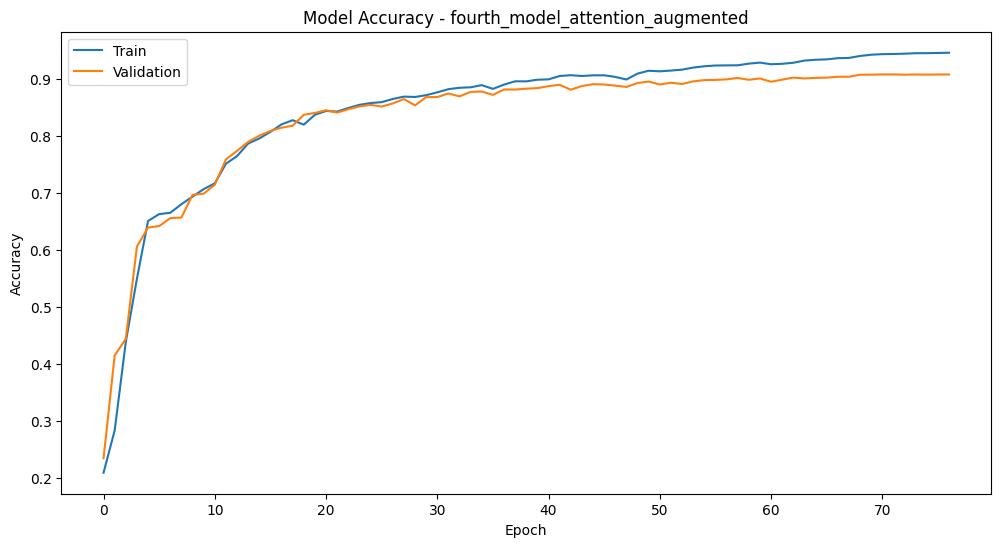

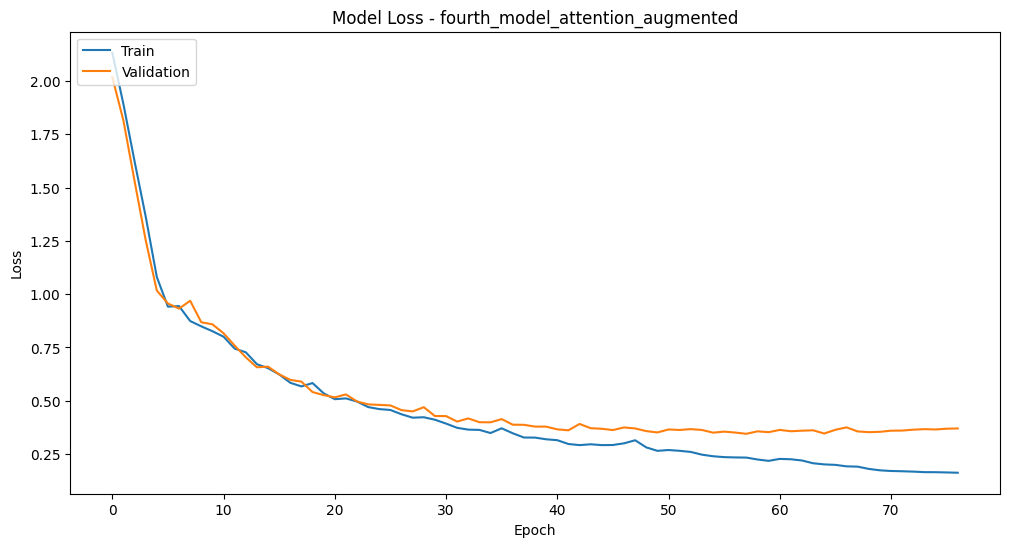

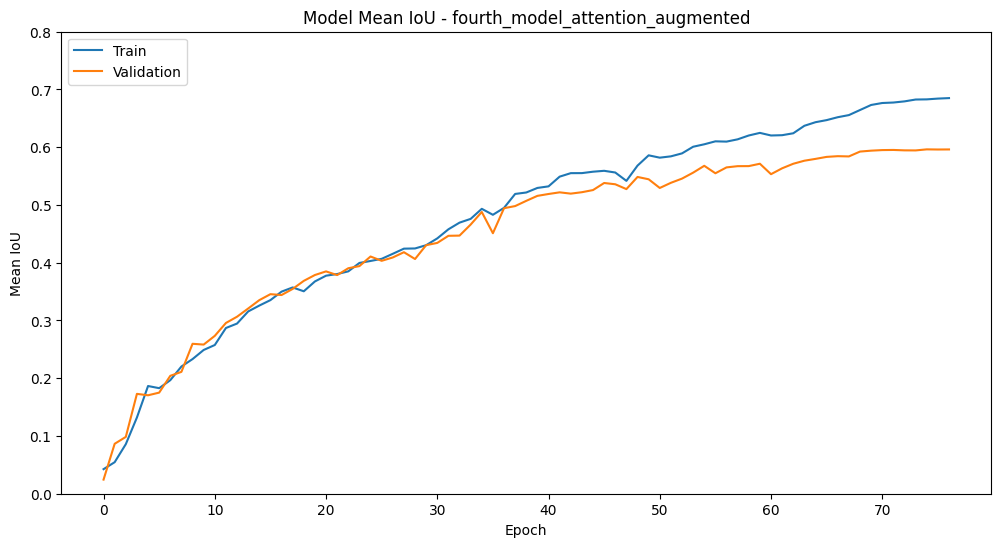

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  fourth_model_attention_augmented
Total params: 35288049
Trainable params: 35288049
Non-trainable params: 0.0
